# Dataset Exploration


Here we are going to explore the dataset with thousands of Mercado Libre items to see which features are more suitable for our model.


First we import the packages we need and set the palette for our plots.


In [1]:
import os

for _ in range(3):
    if os.path.exists(f'{os.getcwd()}/setup.py'):
        break
    os.chdir('..')
print('Current working directory:', os.getcwd())

Current working directory: /Users/dewith/Repos/new-or-used


In [2]:
import json
import re
import unicodedata
from collections import Counter

import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib.ticker import FuncFormatter
from nltk.corpus import stopwords

from src.utils.config import get_dataset_path
from src.utils.styling import apply_styling, make_palette

In [3]:
# Seaborn
colors = make_palette()
palette = colors['palette']
apply_styling(colors)

# Pandas
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 100)
# pd.set_option('display.float_format', lambda x: f'{x:.3f}')
# pd.set_option('display.max_colwidth', 50)

# NLTK
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/dewith/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Data Loading


Read the jsonl file


In [4]:
train_path = get_dataset_path('raw_items_train')
with open(train_path, 'r') as f:
    lines = f.readlines()
    dict_objects = [json.loads(line) for line in lines[:]]
    print('Number of lines:', len(lines))

Number of lines: 90000


Load the data into a pandas dataframe


In [5]:
df = pd.DataFrame.from_records(dict_objects)
print('Shape:', df.shape)

Shape: (90000, 45)


## Data Exploration


### Target variable

Let's see the distribution of the target variable


In [6]:
target_column = 'condition'

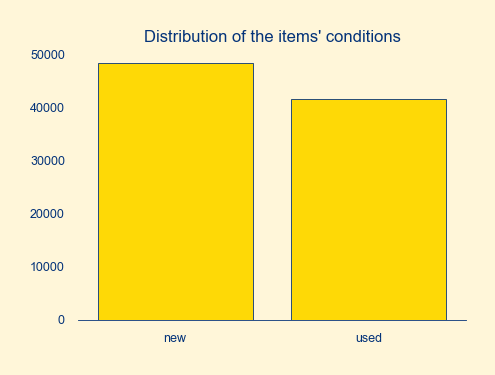

In [7]:
plt.figure(figsize=(5, 3.5), dpi=100)
sns.barplot(
    df[target_column].value_counts(dropna=False),
    edgecolor=colors['lines'],
    linewidth=0.6,
    alpha=1,
    saturation=1,
)
plt.title("Distribution of the items' conditions")
plt.xlabel('')
plt.ylabel('')
sns.despine(left=True)
plt.show()

In [8]:
df[target_column] = df[target_column].map({'new': 1, 'used': 0})
print('Majority class baseline:', df.condition.mean().round(3))

Majority class baseline: 0.537


### Schema


In [9]:
print(json.dumps(dict_objects[0], indent=2))

{
  "seller_address": {
    "country": {
      "name": "Argentina",
      "id": "AR"
    },
    "state": {
      "name": "Capital Federal",
      "id": "AR-C"
    },
    "city": {
      "name": "San Crist\u00f3bal",
      "id": "TUxBQlNBTjkwNTZa"
    }
  },
  "warranty": null,
  "sub_status": [],
  "condition": "new",
  "deal_ids": [],
  "base_price": 80.0,
  "shipping": {
    "local_pick_up": true,
    "methods": [],
    "tags": [],
    "free_shipping": false,
    "mode": "not_specified",
    "dimensions": null
  },
  "non_mercado_pago_payment_methods": [
    {
      "description": "Transferencia bancaria",
      "id": "MLATB",
      "type": "G"
    },
    {
      "description": "Acordar con el comprador",
      "id": "MLAWC",
      "type": "G"
    },
    {
      "description": "Efectivo",
      "id": "MLAMO",
      "type": "G"
    }
  ],
  "seller_id": 8208882349,
  "variations": [],
  "site_id": "MLA",
  "listing_type_id": "bronze",
  "price": 80.0,
  "attributes": [],
  "buying_mod

#### Dtypes


In [10]:
dtypes = {k: type(v) for k, v in dict_objects[0].items()}
for dtype in set(dtypes.values()):
    print(f'{dtype}:')
    for k, v in dtypes.items():
        if v == dtype:
            print(f'  {k}')
    print()

<class 'bool'>:
  accepts_mercadopago
  automatic_relist

<class 'str'>:
  condition
  site_id
  listing_type_id
  buying_mode
  listing_source
  parent_item_id
  category_id
  last_updated
  international_delivery_mode
  id
  currency_id
  thumbnail
  title
  date_created
  secure_thumbnail
  status
  permalink

<class 'dict'>:
  seller_address
  shipping

<class 'list'>:
  sub_status
  deal_ids
  non_mercado_pago_payment_methods
  variations
  attributes
  tags
  coverage_areas
  descriptions
  pictures

<class 'float'>:
  base_price
  price

<class 'int'>:
  seller_id
  stop_time
  initial_quantity
  start_time
  sold_quantity
  available_quantity

<class 'NoneType'>:
  warranty
  official_store_id
  differential_pricing
  original_price
  video_id
  catalog_product_id
  subtitle



### Dictionary columns


##### Seller address

Extract location information from the dictionary


In [11]:
location_features = ['country', 'state', 'city']
for feature in location_features:
    df[feature] = df['seller_address'].apply(
        lambda x, k=feature: x.get(k, {}).get('name', None)
    )

df.drop(columns=['seller_address'], inplace=True)

##### Shipping

Extract shipping information from the dictionary


In [12]:
shipping_df = pd.json_normalize(df['shipping'])
shipping_df.columns = [
    'local_pick_up',
    'shipping_methods',
    'shipping_tags',
    'free_shipping',
    'shipping_mode',
    'dimensions',
    'shipping_free_methods',
]

df = pd.concat([df.drop('shipping', axis=1), shipping_df], axis=1)

### List columns


In [13]:
list_cols = [
    'sub_status',
    'deal_ids',
    'non_mercado_pago_payment_methods',
    'variations',
    'attributes',
    'tags',
    'coverage_areas',
    'descriptions',
    'pictures',
]

In [14]:
for col in list_cols:
    print(col)
    try:
        values, counts = np.unique(df[col].values, return_counts=True)
        print('Unique values:', len(values))
        if len(values) < 10:
            print('\n'.join([f'{v}: {c}' for v, c in zip(values, counts)]))
    except Exception as e:
        print(e)
    print('-' * 60)

sub_status
Unique values: 4
[]: 89109
['deleted']: 7
['expired']: 13
['suspended']: 871
------------------------------------------------------------
deal_ids
Unique values: 31
------------------------------------------------------------
non_mercado_pago_payment_methods
'<' not supported between instances of 'dict' and 'dict'
------------------------------------------------------------
variations
'<' not supported between instances of 'dict' and 'dict'
------------------------------------------------------------
attributes
'<' not supported between instances of 'dict' and 'dict'
------------------------------------------------------------
tags
Unique values: 8
[]: 22412
['dragged_bids_and_visits']: 65315
['dragged_visits']: 464
['dragged_visits', 'free_relist']: 259
['good_quality_thumbnail']: 346
['good_quality_thumbnail', 'dragged_bids_and_visits']: 1191
['poor_quality_thumbnail']: 3
['poor_quality_thumbnail', 'dragged_bids_and_visits']: 10
--------------------------------------------

##### Substatus

Make it a string instead of a list


In [15]:
df['sub_status'] = df['sub_status'].apply(lambda x: x[0] if x else np.nan)

#### Deal ids

Drop this column since most of the values are empty


In [16]:
df.drop(columns=['deal_ids'], inplace=True)

#### Non mercado pago payment methods

Make each payment method a flag column


In [17]:
all_payment_methods = set()
for x in df['non_mercado_pago_payment_methods'].values:
    if x:
        for method in x:
            all_payment_methods.add(method['description'])
all_payment_methods

{'Acordar con el comprador',
 'American Express',
 'Cheque certificado',
 'Contra reembolso',
 'Diners',
 'Efectivo',
 'Giro postal',
 'MasterCard',
 'Mastercard Maestro',
 'MercadoPago',
 'Tarjeta de crédito',
 'Transferencia bancaria',
 'Visa',
 'Visa Electron'}

In [18]:
def extract_payment_methods(payment_methods):
    """Extract payment methods from a list of dictionaries."""
    if not payment_methods:
        return None

    card_prefixes = {'visa', 'mastercard', 'american'}

    def categorize_method(method):
        description = method['description'].lower()
        return (
            'pay_tarjeta'
            if any(description.startswith(prefix) for prefix in card_prefixes)
            else f'pay_{description.split()[0]}'
        )

    unique_methods = {categorize_method(method) for method in payment_methods}
    return ' / '.join(unique_methods)


# Extract payment methods
payment_df = df['non_mercado_pago_payment_methods'].apply(extract_payment_methods)
payment_methods_dummies = payment_df.str.get_dummies(sep=' / ')
payment_methods_dummies['n_payment_methods'] = payment_methods_dummies.sum(axis=1)
df = pd.concat([df, payment_methods_dummies], axis=1)
df.drop(columns=['non_mercado_pago_payment_methods'], inplace=True)

#### Variations

Make a binary column if the item has variations or not


In [19]:
df['has_variations'] = df['variations'].apply(lambda x: 1 if x else 0)
df.drop(columns=['variations'], inplace=True)

#### Attributes

Extract the attributes from the dictionary and use the most informative ones


In [20]:
def clean_name(name):
    """Normalize attribute names"""
    name = re.sub(r'[^\w\s]', '', name)
    name = re.sub(r'\s+', ' ', name)
    name = re.sub(r'\b(de|del)\s+', '', name, flags=re.IGNORECASE)
    name = name.replace(' ', '_').lower().strip()
    name = unicodedata.normalize('NFKD', name).encode('ascii', 'ignore').decode('utf-8')
    return name


# Flatten and consolidate attributes
len_mask = df['attributes'].apply(lambda x: len(x)) > 0
attributes_df = pd.json_normalize(df.loc[len_mask, 'attributes'])
all_attributes = attributes_df.values.tolist()

attributes = []
for row in all_attributes:
    for attribute in row:
        if attribute:
            attribute_name = clean_name(attribute['name'])
            value = clean_name(attribute['value_name'])
            attributes.append({'attribute': attribute_name, 'value': value})

attributes_df = pd.DataFrame(attributes)
common_attributes = (attributes_df['attribute'].value_counts() >= 100).index.tolist()

In [21]:
def consolidate_attributes(attributes):
    """Consolidate attributes"""
    new_attributes = {}
    for attribute in attributes:
        attribute_name = clean_name(attribute['name'])
        value = clean_name(attribute['value_name'])
        if (attribute_name in common_attributes) and ('pieza' not in attribute_name):
            new_attributes[f'attr_{attribute_name}'] = value

    return new_attributes


# Consolidate attributes
attributes_dict_df = df['attributes'].apply(consolidate_attributes).to_frame()
attributes_normalized_df = pd.json_normalize(attributes_dict_df['attributes'])
attributes_dict_df = pd.concat([df[['condition']], attributes_normalized_df], axis=1)
attributes_dict_df.fillna('missing', inplace=True)

The hypothesis is that what is informative is not the value of the attribute but if the
item has that attribute or not. For example, the value of the attribute "antigüedad" is not
informative, but if the item has the attribute "antigüedad" is informative for our task.

To test this hypothesis we will use the gini impurity to see which attributes are more informative.


In [22]:
def gini_impurity(value_counts):
    n = value_counts.sum()
    p_sum = 0
    for key in value_counts.keys():
        p_sum = p_sum + (value_counts[key] / n) * (value_counts[key] / n)
    gini = 1 - p_sum
    return gini


# Calculate Gini Impurity for the class
class_value_counts = attributes_dict_df[target_column].value_counts()
gini_class = gini_impurity(class_value_counts)

# Calculate Gini Impurity for each attribute
gini_attiribute = {}
for attribute_name in attributes_dict_df.columns[1:]:
    # We remove the missing values to compute the gini of the attribute alone.
    # Since most items have no attributes, the nulls bias the gini a lot.
    attributes_dict_df_A = attributes_dict_df[['condition', attribute_name]].query(
        f'{attribute_name} != "missing"'
    )
    attribute_values = attributes_dict_df_A[attribute_name].value_counts()
    gini_A = 0
    for key in attribute_values.keys():
        key_mask = attributes_dict_df_A[attribute_name] == key
        df_k = attributes_dict_df_A[target_column][key_mask].value_counts()
        n_k = attribute_values[key]
        n = attributes_dict_df_A.shape[0]
        gini_k = gini_impurity(df_k)
        gini_A += (n_k / n) * gini_k

    gini_attiribute[attribute_name] = gini_A

gini_df = pd.DataFrame.from_dict(gini_attiribute, orient='index', columns=['gini'])

Let's plot the distribution of the gini impurity for each attribute



Gini Impurity of the class is 0.497


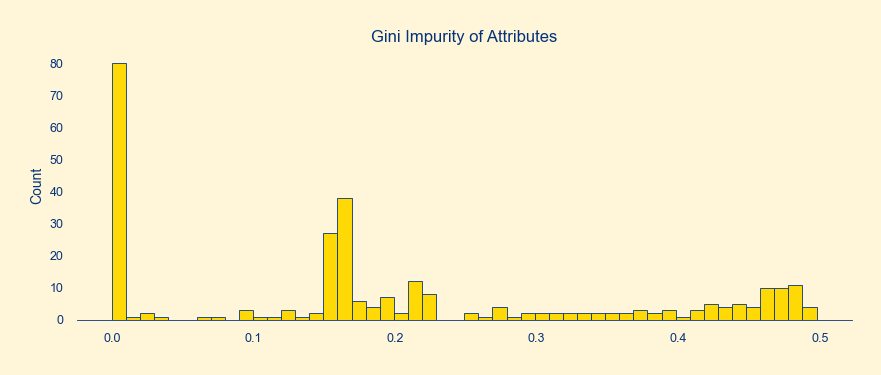

In [23]:
print(f'\nGini Impurity of the class is {gini_class:.3f}')

plt.figure(figsize=(10, 3.5), dpi=100)
sns.histplot(
    gini_df.gini,
    bins=50,
    stat='count',
    color='#fed906',
    edgecolor=colors['lines'],
    linewidth=0.6,
    alpha=1,
)
plt.title('Gini Impurity of Attributes')
plt.xlabel('')
sns.despine(left=True)
plt.show()

Let's keep the attributes below 0.15 of gini impurity


In [24]:
valid_attributes = gini_df[gini_df['gini'] < 0.15].index.tolist()
print(f'Number of valid attributes: {len(valid_attributes)}')

Number of valid attributes: 98


Now let process the column in the main dataframe


In [25]:
def consolidate_attributes(attributes):
    """Consolidate attributes"""
    if not attributes:
        return None
    new_attributes = {}
    for attribute in attributes:
        attribute_name = 'attr_' + clean_name(attribute['name'])
        value = clean_name(attribute['value_name'])
        if attribute_name in valid_attributes:
            new_attributes[f'{attribute_name}'] = value
    return new_attributes


# Consolidate attributes
attributes_series = df['attributes'].apply(consolidate_attributes)
attributes_normalized_df = pd.json_normalize(attributes_series)
attributes_normalized_df['n_attributes'] = attributes_normalized_df.notna().sum(axis=1)

# Join with original DataFrame
df = pd.concat([df, attributes_normalized_df], axis=1)
df.drop(columns=['attributes'], inplace=True)

#### Tags

Turn the tags into flag columns


In [26]:
df['tags_str'] = df['tags'].apply(lambda x: ' / '.join(x))
tags_dummies = df['tags_str'].str.get_dummies(sep=' / ')
df = pd.concat([df, tags_dummies], axis=1)
df.drop(columns=['tags', 'tags_str'], inplace=True)

#### Coverage areas

Drop this column since it is empty


In [27]:
# coverage_areas
# Drop this column since it is empty
df.drop(columns=['coverage_areas'], inplace=True)

#### Descriptions

Drop descriptions since they are all unique


In [28]:
print(df.descriptions.sample(3))
df[['descriptions']].apply(lambda x: x.str.len().value_counts(dropna=False))

14553    [{'id': 'MLA9482296254-934430437'}]
43599    [{'id': 'MLA1455107304-930290865'}]
49736    [{'id': 'MLA2694705850-906364337'}]
Name: descriptions, dtype: object


,descriptions
descriptions,
1,87583
0,2417


In [29]:
df.drop(columns=['descriptions'], inplace=True)

#### Pictures

Only keep the number of pictures and the average resolution


In [30]:
df['n_pictures'] = df['pictures'].apply(len)

In [31]:
def get_pixels(size):
    """Get the number of pixels of a picture."""
    w, h = map(int, size.split('x'))
    return w * h


df['pixels_per_picture'] = df['pictures'].apply(
    lambda x: np.median(
        [get_pixels(picture['size']) for picture in x if picture['size']]
    )
    if x
    else np.nan
)

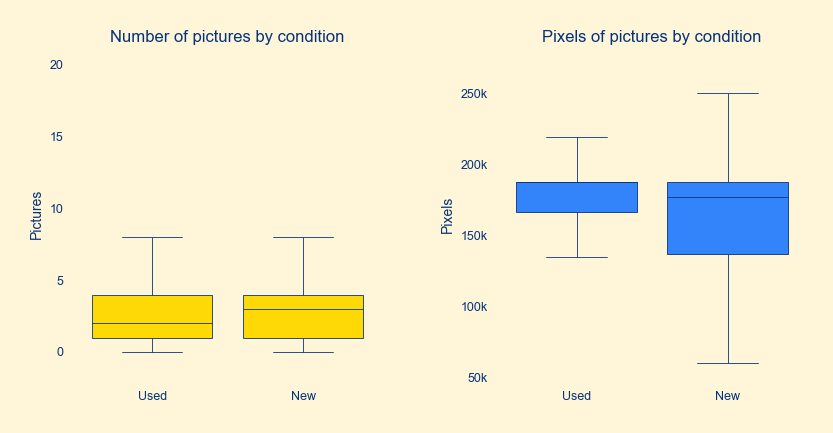

In [32]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 4), dpi=100)

std_params = {
    'x': 'condition',
    'data': df,
    'fliersize': 0,
    'linewidth': 0.6,
    'linecolor': colors['lines'],
    'legend': False,
    'saturation': 1,
}

# Number of pictures plot
sns.boxplot(y='n_pictures', ax=axes[0], **std_params)
axes[0].set_title('Number of pictures by condition')
axes[0].set_ylabel('Pictures')
axes[0].set_ylim(None, 21)

# Image size plot
sns.boxplot(y='pixels_per_picture', color=palette[2], ax=axes[1], **std_params)
axes[1].set_title('Pixels of pictures by condition')
axes[1].set_ylabel('Pixels')
axes[1].set_ylim(50_000, 280_000)
axes[1].yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x / 1_000:.0f}k'))

# Common ax settings
for ax in axes:
    ax.set_xlabel('')
    ax.set_xticks([0, 1])
    ax.set_xticklabels(['Used', 'New'])
    ax.spines[['left', 'bottom']].set_visible(False)

plt.tight_layout(w_pad=5)
plt.show()

In [33]:
df.drop(columns=['pictures'], inplace=True)

#### Shipping methods

Drop this column since it is empty


In [34]:
df.shipping_methods.fillna('', inplace=True)
df.shipping_methods.apply(lambda x: len(x) if x else 0).value_counts()

/var/folders/4g/4bjx__p542l55rbxgzvj4tfh0000gn/T/ipykernel_14705/3097521624.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df.shipping_methods.fillna('', inplace=True)


shipping_methods
0    90000
Name: count, dtype: int64

In [35]:
df.drop(columns=['shipping_methods'], inplace=True)

#### Shipping tags

Drop this since it is empty almost all the time


In [36]:
df.shipping_tags.value_counts()

shipping_tags
[]                               89941
[relisted_with_modifications]       50
[free_method_upgraded]               9
Name: count, dtype: int64

In [37]:
df.drop(columns=['shipping_tags'], inplace=True)

#### Shipping free methods

Let's turn it into a flag


In [38]:
df.shipping_free_methods.value_counts(dropna=False)

shipping_free_methods
NaN                                                                                                                                 87311
[{'rule': {'value': None, 'free_mode': 'country'}, 'id': 73328}]                                                                     2641
[{'rule': {'value': None, 'free_mode': 'country'}, 'id': 73330}]                                                                       37
[{'rule': {'value': None, 'free_mode': 'country'}, 'id': 501145}]                                                                       6
[{'rule': {'value': None, 'free_mode': 'country'}, 'id': 501146}]                                                                       4
[{'rule': {'value': None, 'free_mode': 'country'}, 'id': 73328}, {'rule': {'value': None, 'free_mode': 'country'}, 'id': 73330}]        1
Name: count, dtype: int64

In [39]:
df['has_free_shipping'] = df.shipping_free_methods.apply(
    lambda x: 1 if isinstance(x, list) else 0
)

df.drop(['shipping_free_methods'], axis=1, inplace=True)

#### Check for lists and dict columns remaining


In [40]:
all_columns = df.columns.tolist()
attr_columns = [col for col in all_columns if 'attr' in col]
non_attr_columns = [col for col in all_columns if col not in attr_columns]

In [41]:
object_columns = df[non_attr_columns].select_dtypes(include='object').columns.tolist()
dtypes = {}
for col in object_columns:
    dtypes[col] = type(df[col].iloc[0])

for k, v in dtypes.items():
    print(f'{k}: {v}')

warranty: <class 'NoneType'>
sub_status: <class 'float'>
site_id: <class 'str'>
listing_type_id: <class 'str'>
buying_mode: <class 'str'>
listing_source: <class 'str'>
parent_item_id: <class 'str'>
category_id: <class 'str'>
last_updated: <class 'str'>
international_delivery_mode: <class 'str'>
id: <class 'str'>
differential_pricing: <class 'NoneType'>
currency_id: <class 'str'>
thumbnail: <class 'str'>
title: <class 'str'>
date_created: <class 'str'>
secure_thumbnail: <class 'str'>
status: <class 'str'>
video_id: <class 'NoneType'>
subtitle: <class 'NoneType'>
permalink: <class 'str'>
country: <class 'str'>
state: <class 'str'>
city: <class 'str'>
shipping_mode: <class 'str'>
dimensions: <class 'NoneType'>


Ok, let's keep this one since not accepting Mercado Pago is a little bit more common in used items.


### Categorical columns


#### Droppable columns


In [42]:
def describe_cat_col(df, col: str):
    """Prints the distribution of a categorical column."""
    print(f'COLUMN: {col}')

    # Eval nulls
    size = len(df)
    n_nulls = df[col].isnull().sum()
    print(f'-> Nulls: {n_nulls} ({n_nulls / size:.1%})')

    # Eval unique values
    n_unique = df[col].nunique()
    print(f'-> Unique values: {n_unique}')
    if n_unique < 10:
        print(df[col].value_counts())
    else:
        print(df[col].value_counts().head(5))
        print('  ...')

    return n_nulls, n_unique

In [43]:
cat_cols = [
    col
    for col in df.select_dtypes(include='object').columns.tolist()
    if 'attr' not in col
]

In [44]:
cat_cols

['warranty',
 'sub_status',
 'site_id',
 'listing_type_id',
 'buying_mode',
 'listing_source',
 'parent_item_id',
 'category_id',
 'last_updated',
 'international_delivery_mode',
 'id',
 'differential_pricing',
 'currency_id',
 'thumbnail',
 'title',
 'date_created',
 'secure_thumbnail',
 'status',
 'video_id',
 'subtitle',
 'permalink',
 'country',
 'state',
 'city',
 'shipping_mode',
 'dimensions']

In [45]:
df_size = len(df)
drop_cols = []
for col in cat_cols:
    # Take a glance at the column
    n_nulls, n_unique = describe_cat_col(df, col)

    # Eval if column should be dropped
    too_many_nulls = n_nulls / df_size > 0.9
    too_many_unique = n_unique > (df_size * 0.5)
    all_the_same = n_unique == 1
    if too_many_nulls or too_many_unique or all_the_same:
        if col not in ('title'):
            drop_cols.append(col)
            print('❌ Drop it')
    else:
        print('✅ Ok to keep')

    print('-' * 80)

COLUMN: warranty
-> Nulls: 54757 (60.8%)
-> Unique values: 9536
warranty
Sí              5107
Sin garantía    4907
SI               545
6 meses          489
6 MESES          361
Name: count, dtype: int64
  ...
✅ Ok to keep
--------------------------------------------------------------------------------
COLUMN: sub_status
-> Nulls: 89109 (99.0%)
-> Unique values: 3
sub_status
suspended    871
expired       13
deleted        7
Name: count, dtype: int64
❌ Drop it
--------------------------------------------------------------------------------
COLUMN: site_id
-> Nulls: 0 (0.0%)
-> Unique values: 1
site_id
MLA    90000
Name: count, dtype: int64
❌ Drop it
--------------------------------------------------------------------------------
COLUMN: listing_type_id
-> Nulls: 0 (0.0%)
-> Unique values: 7
listing_type_id
bronze          56904
free            19260
silver           8195
gold_special     2693
gold             2170
gold_premium      765
gold_pro           13
Name: count, dtype: int64
✅ 

- The status of the item can be dropped since we can expect to use the model to predict new items that are active at the beggining.

- We cannot drop the title since it contains valuable information for the model.


In [46]:
drop_cols.append('status')

In [47]:
print('Columns to keep:', [col for col in cat_cols if col not in drop_cols])
print('Columns to drop:', drop_cols)

Columns to keep: ['warranty', 'listing_type_id', 'buying_mode', 'category_id', 'currency_id', 'title', 'country', 'state', 'city', 'shipping_mode']
Columns to drop: ['sub_status', 'site_id', 'listing_source', 'parent_item_id', 'last_updated', 'international_delivery_mode', 'id', 'differential_pricing', 'thumbnail', 'date_created', 'secure_thumbnail', 'video_id', 'subtitle', 'permalink', 'dimensions', 'status']


In [48]:
df.drop(drop_cols, axis=1, inplace=True)

In [49]:
[
    'warranty',
    'listing_type_id',
    'buying_mode',
    'category_id',
    'currency_id',
    'title',
    'country',
    'state',
    'city',
    'shipping_mode',
]

['warranty',
 'listing_type_id',
 'buying_mode',
 'category_id',
 'currency_id',
 'title',
 'country',
 'state',
 'city',
 'shipping_mode']

#### Warranty


In [50]:
def normalize_text(text, stops=None):
    """
    Normalize text by converting to lowercase, removing accents, punctuation,
    special characters, extra whitespace, and stopwords.
    """
    if pd.isna(text):
        return None

    # Convert to lowercase
    text = text.lower()
    # Remove accents
    text = unicodedata.normalize('NFKD', text)
    # Remove punctuation and special characters
    # text = re.sub(r'[^\w\s]|\d', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    # Remove stopwords
    if stops:
        text = ' '.join([word for word in text.split() if word not in stops])
    return text

In [51]:
df['warranty_norm'] = df.warranty.apply(normalize_text)

In [52]:
np.random.choice(df.warranty_norm.unique(), 5)

array(['productos artesanales',
       'los libros son revisados antes de su publicacion por lo que estan en el estado que se indica',
       'si el producto no respeta las condiciones de venta se devolvera el importe abonado',
       'idraet', '6 meses de garantia del fabricante'], dtype=object)

Given the fact the users just input natural text into this field, it's too noisy to be useful for now.


In [53]:
df.drop(['warranty', 'warranty_norm'], axis=1, inplace=True)

#### Country, State, City


In [54]:
loc_cols = ['country', 'state', 'city']
df.groupby(loc_cols).size().to_frame().sort_values(by=0, ascending=False).head(50)

0
country   state           city                    
Argentina Capital Federal CABA                3693
                          Palermo             2993
                          Capital Federal     2990
                          Buenos Aires        2846
                          Caballito           2671
                          Belgrano            2098
                          buenos aires        1632
                          capital federal     1596
          Santa Fe        Rosario             1537
          Capital Federal Flores              1447
                          Villa Crespo        1417
                          Mataderos           1400
                          Almagro             1100
                          caba                1053
                          Balvanera           1050
          Buenos Aires    Avellaneda          1009
                          La Plata             881
                          San Isidro           881
                          Mar del Plata        881
          Capital Federal CAPITAL FEDERAL      860
                          Recoleta             841
          Buenos Aires    Quilmes              783
                          Lanús                783
                          General San Martín   772
          Capital Federal Floresta             744
                          Villa Urquiza        723
          Buenos Aires    Lomas de Zamora      699
          Capital Federal BUENOS AIRES         607
                          San Telmo            606
                          Boedo                598
                          Villa Devoto         583
          Córdoba         Córdoba              565
          Capital Federal Congreso             557
                          Caba                 536
          Buenos Aires    Morón                499
          Capital Federal Villa del Parque     488
          Buenos Aires    Bragado              448
          Capital Federal Monserrat            444
          Buenos Aires    Ituzaingó            440
          Capital Federal Paternal             435
          Buenos Aires    Vicente López        430
                          Caseros              430
          Capital Federal Microcentro          423
                          Barracas             408
                          C.A.B.A.             397
          Buenos Aires    Pilar                367
                          Tigre                348
                          Ciudad Madero        337
                          Hurlingham           333
          Capital Federal Colegiales           332

In [55]:
for col in loc_cols:
    print(f'Unique values in {col}:', df[col].nunique())

Unique values in country: 2
Unique values in state: 25
Unique values in city: 3480


These columns are inputed manually, except for country.

We'll drop them since it's neither clean nor objectively useful for the model


In [56]:
df.drop(loc_cols, axis=1, inplace=True)

#### Listing type ID

Let's leave this as is.


In [57]:
df.listing_type_id.value_counts()

listing_type_id
bronze          56904
free            19260
silver           8195
gold_special     2693
gold             2170
gold_premium      765
gold_pro           13
Name: count, dtype: int64

#### Shipping mode

Let's leave it as it is


In [58]:
df.shipping_mode.value_counts()

shipping_mode
me2              46059
not_specified    40725
custom            3130
me1                 86
Name: count, dtype: int64

In [59]:
df.shipping_mode = df.shipping_mode.replace(
    {'me2': 'mercado_envios', 'me1': 'mercado_envios'}
)

#### Buying mode


In [60]:
df.buying_mode.value_counts()

buying_mode
buy_it_now    87311
classified     1982
auction         707
Name: count, dtype: int64

#### Currency ID


In [61]:
df.currency_id.value_counts()

currency_id
ARS    89496
USD      504
Name: count, dtype: int64

We can do something with this column but let's keep it as it is, in case new countries are included in the training data.


#### Category ID

Reduce the cardinality of the column by grouping the categories that have less than 200 items


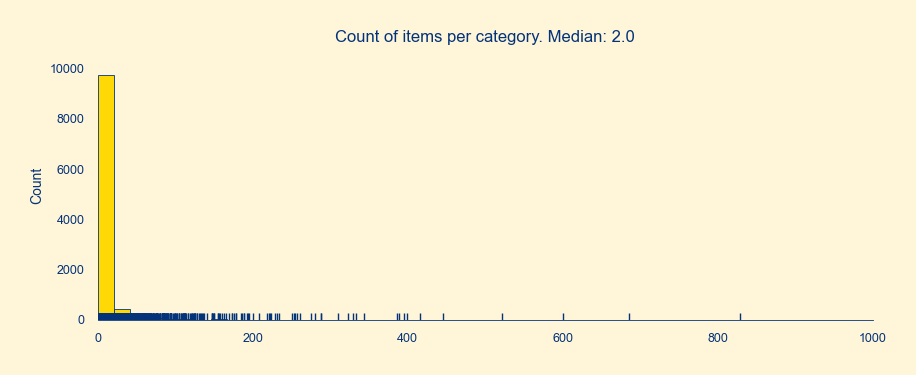

In [62]:
plt.figure(figsize=(10, 3.5), dpi=100)
category_counts = df.category_id.value_counts()
sns.histplot(
    category_counts, bins=200, edgecolor=colors['lines'], linewidth=0.6, alpha=1
)
sns.rugplot(category_counts, color=colors['lines'])
plt.title(
    'Count of items per category. Median: {:.1f}'.format(category_counts.median())
)
plt.xlabel('')
plt.xlim(0, 1000)
sns.despine(left=True)
plt.show()

In [63]:
valid_categories = category_counts.where(category_counts > 200).dropna().index
df.category_id = df.category_id.where(df.category_id.isin(valid_categories), 'Other')

#### Title

Normalize the title column and get the length of the title


In [64]:
df['title_norm'] = df.title.apply(normalize_text, stops=set(stopwords.words('spanish')))
df['title_len'] = df.title_norm.str.len()

df.drop('title', axis=1, inplace=True)

Let's see the distribution of the title length per label


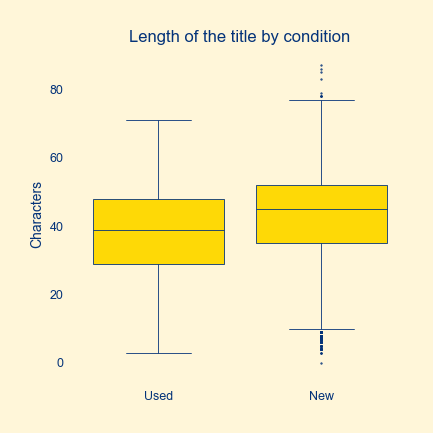

In [65]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
sns.boxplot(
    x='condition',
    y='title_len',
    data=df,
    fliersize=0.6,
    linewidth=0.6,
    linecolor=colors['lines'],
    legend=False,
    saturation=1,
    ax=ax,
)
ax.set_title('Length of the title by condition')
ax.set_ylabel('Characters')
ax.set_xlabel('')
ax.set_xticks([0, 1])
ax.set_xticklabels(['Used', 'New'])
ax.spines[['left', 'bottom']].set_visible(False)

plt.tight_layout()
plt.show()

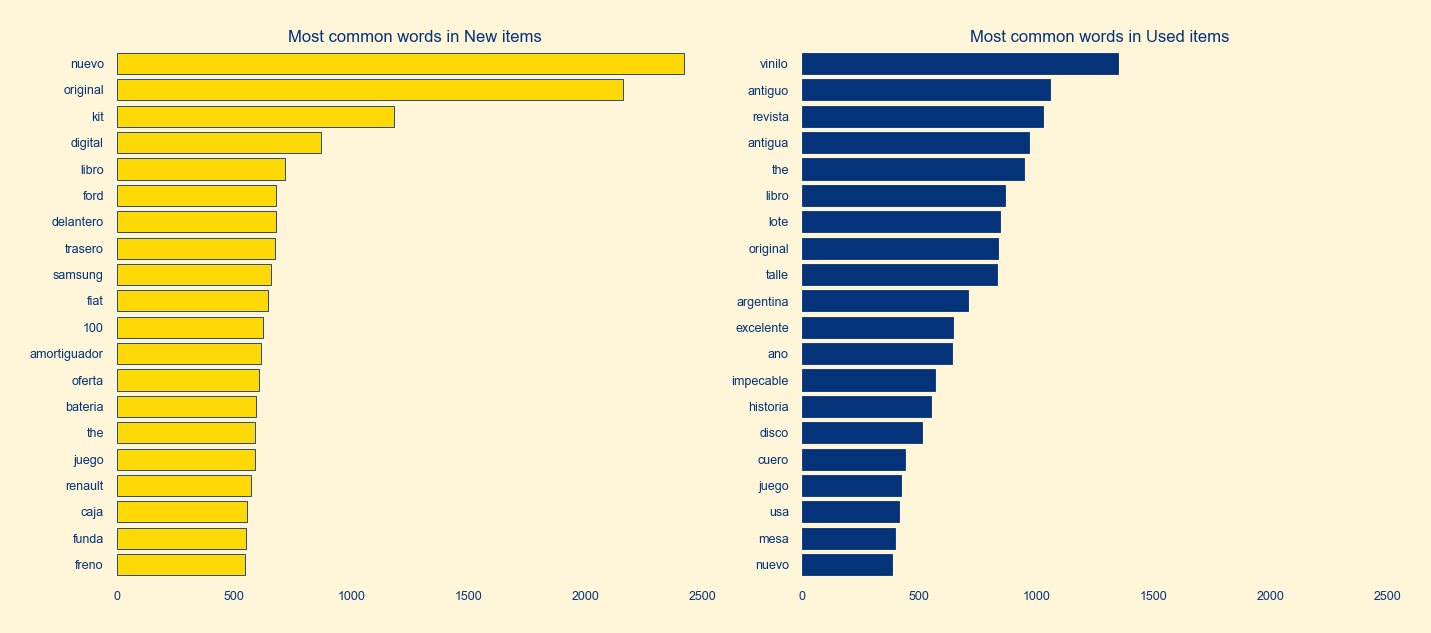

In [66]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharex=True)

top_n = 20
words_count = df.title_norm.str.split().apply(len)
conditions = {0: 'Used', 1: 'New'}
for i, condition in enumerate(df.condition.unique()):
    all_text = ' '.join(
        df.query(f'condition == {condition}')['title_norm'].dropna().astype(str)
    )
    words = [w for w in all_text.split() if len(w) > 2]
    word_freq = Counter(words)
    top_words = word_freq.most_common(top_n)
    words, counts = zip(*top_words)

    sns.barplot(
        x=counts,
        y=words,
        ax=axes[i],
        color=palette[i],
        edgecolor=colors['lines'],
        linewidth=0.6,
        alpha=1,
        saturation=1,
    )

    axes[i].set_title(f'Most common words in {conditions[condition]} items')
    axes[i].set_ylabel(''), axes[i].set_xlabel('')
    axes[i].spines[['left', 'bottom']].set_visible(False)

plt.tight_layout()
plt.show()

### Numerical columns


In [67]:
numerical_cols = df.select_dtypes(include='number').columns.to_list()
_ = [print(col) for col in numerical_cols]

condition
base_price
seller_id
price
official_store_id
original_price
stop_time
catalog_product_id
initial_quantity
start_time
sold_quantity
available_quantity
pay_acordar
pay_cheque
pay_contra
pay_diners
pay_efectivo
pay_giro
pay_mercadopago
pay_tarjeta
pay_transferencia
n_payment_methods
has_variations
n_attributes
dragged_bids_and_visits
dragged_visits
free_relist
good_quality_thumbnail
poor_quality_thumbnail
n_pictures
pixels_per_picture
has_free_shipping
title_len


- [x] base_price
- [x] seller_id
- [x] price
- [x] official_store_id
- [x] original_price
- [x] stop_time
- [ ] catalog_product_id
- [x] initial_quantity
- [x] start_time
- [x] sold_quantity
- [x] available_quantity


#### Seller ID

Drop the seller ID since it is not relevant for the model


In [68]:
df.drop('seller_id', axis=1, inplace=True)

#### Official store ID

Let's turn this bad boy into a flag column.


In [69]:
df['is_official_store'] = df.official_store_id.apply(lambda x: 1 if pd.notna(x) else 0)

In [70]:
df.is_official_store.value_counts()

is_official_store
0    89255
1      745
Name: count, dtype: int64

In [71]:
df.drop('official_store_id', axis=1, inplace=True)

#### Catalog product ID


In [72]:
df.catalog_product_id.value_counts(dropna=False)

catalog_product_id
NaN          89993
800744.0         1
5093232.0        1
3050291.0        1
5126117.0        1
94404.0          1
3051112.0        1
3053998.0        1
Name: count, dtype: int64

🙃


In [73]:
df.drop('catalog_product_id', axis=1, inplace=True)

#### Price, original price, and base price

Let's see the distribution of the price and base price


In [74]:
df.groupby('condition').price.describe().apply(lambda s: s.apply('{0:,.1f}'.format))

,count,mean,std,min,25%,50%,75%,max
condition,,,,,,,,
0,"41,648.0","67,265.1","7,743,572.4",1.0,65.0,150.0,548.2,"1,111,111,111.0"
1,"48,352.0","49,672.4","10,106,294.8",0.8,140.0,350.0,995.6,"2,222,222,222.0"


In [75]:
df.groupby('condition').base_price.describe().apply(
    lambda s: s.apply('{0:,.1f}'.format)
)

,count,mean,std,min,25%,50%,75%,max
condition,,,,,,,,
0,"41,648.0","67,265.1","7,743,572.4",1.0,65.0,150.0,546.2,"1,111,111,111.0"
1,"48,352.0","49,672.2","10,106,294.8",0.8,140.0,350.0,995.1,"2,222,222,222.0"


In [76]:
df.groupby('condition').original_price.describe().apply(
    lambda s: s.apply('{0:,.1f}'.format)
)

,count,mean,std,min,25%,50%,75%,max
condition,,,,,,,,
0,0.0,nan,nan,nan,nan,nan,nan,nan
1,130.0,"1,492.5","1,954.9",120.0,449.0,850.0,"1,500.0","12,248.0"


Drop the base price since it is very similar to the price.
And let's drop original price too, because is null most of the time.

Also, we can see that the price is a little bit more higher in used items.


In [77]:
df.drop(['base_price', 'original_price'], axis=1, inplace=True)

#### Start time and stop time


In [78]:
df[['start_time', 'stop_time']].head()

,start_time,stop_time
0,1441485773000,1446669773000
1,1443290910000,1448474910000
2,1441843027000,1447027027000
3,1443466076000,1449191596000
4,1440454040000,1445638040000


In [79]:
df['start_time'] = pd.to_datetime(df['start_time'], unit='ms')
df['start_hour'] = df['start_time'].dt.hour

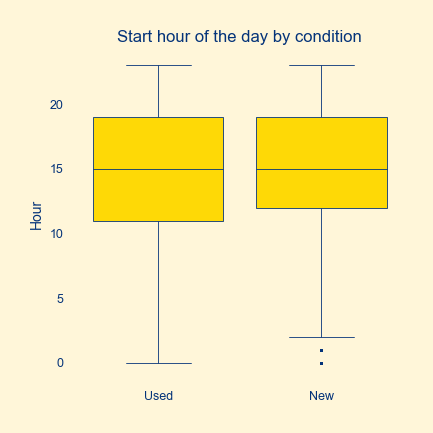

In [80]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
sns.boxplot(
    x='condition',
    y='start_hour',
    data=df,
    fliersize=0.6,
    linewidth=0.6,
    linecolor=colors['lines'],
    legend=False,
    saturation=1,
    ax=ax,
)
ax.set_title('Start hour of the day by condition')
ax.set_ylabel('Hour')
ax.set_xlabel('')
ax.set_xticks([0, 1])
ax.set_xticklabels(['Used', 'New'])
ax.spines[['left', 'bottom']].set_visible(False)

plt.tight_layout()
plt.show()

Let's drop both since we are not seeing any correlation with the target variable.


In [81]:
df.drop(['start_time', 'start_hour', 'stop_time'], axis=1, inplace=True)

#### Initial quantity, sold quantity and available quantity


Let's take a look to the correlation between initial quantity and condition


In [82]:
df.groupby('condition').initial_quantity.describe().apply(
    lambda s: s.apply('{0:,.1f}'.format)
)

,count,mean,std,min,25%,50%,75%,max
condition,,,,,,,,
0,"41,648.0",2.1,58.3,1.0,1.0,1.0,1.0,"9,999.0"
1,"48,352.0",63.3,570.4,1.0,1.0,2.0,9.0,"9,999.0"


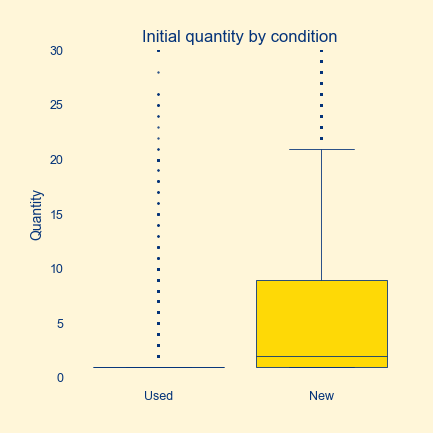

In [83]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
sns.boxplot(
    x='condition',
    y='initial_quantity',
    data=df,
    fliersize=0.6,
    linewidth=0.6,
    linecolor=colors['lines'],
    legend=False,
    saturation=1,
    ax=ax,
)
ax.set_title('Initial quantity by condition')
ax.set_ylabel('Quantity')
ax.set_xlabel('')
ax.set_xticks([0, 1])
ax.set_xticklabels(['Used', 'New'])
ax.set_ylim(0, 30)
ax.spines[['left', 'bottom']].set_visible(False)

plt.tight_layout()
plt.show()

Not surprisingly, the initial quantity is higher in new items and tend to be 1 in used items.

Let's just use the initial quantity since this is what we will have at the beggining.


In [84]:
df.drop(['available_quantity', 'sold_quantity'], axis=1, inplace=True)

### Boolean columns


In [85]:
bool_cols = df.select_dtypes(include='bool').columns.to_list()

In [86]:
bool_cols

['accepts_mercadopago', 'automatic_relist', 'local_pick_up', 'free_shipping']

#### Accepts mercadopago


In [87]:
print(df.accepts_mercadopago.value_counts())

(
    pd.crosstab(df.accepts_mercadopago, df.condition, normalize='columns', margins=True)
    * 100
).round(1)

accepts_mercadopago
True     88018
False     1982
Name: count, dtype: int64


condition,0,1,All
accepts_mercadopago,,,
False,3.7,0.9,2.2
True,96.3,99.1,97.8


Ok, let's keep this one since not accepting Mercado Pago is a little bit more common in used items.


In [88]:
df.accepts_mercadopago = df.accepts_mercadopago.astype(int)

#### Automatic relist


In [89]:
print(df.automatic_relist.value_counts())

(
    pd.crosstab(df.automatic_relist, df.condition, normalize='columns', margins=True)
    * 100
).round(1)

automatic_relist
False    85773
True      4227
Name: count, dtype: int64


condition,0,1,All
automatic_relist,,,
False,99.5,91.6,95.3
True,0.5,8.4,4.7


Based on the cross table, we can see that the automatic relist is not very common when the item is used


In [90]:
df.automatic_relist = df.automatic_relist.astype(int)

#### Local pick up

In [91]:
print(df.local_pick_up.value_counts())

(
    pd.crosstab(df.local_pick_up, df.condition, normalize='columns', margins=True) * 100
).round(1)

local_pick_up
True     71577
False    18423
Name: count, dtype: int64


condition,0,1,All
local_pick_up,,,
False,22.3,18.9,20.5
True,77.7,81.1,79.5


Same distribution of local pick up for new and used items, let's drop it.

In [94]:
df.drop('local_pick_up', axis=1, inplace=True)

#### Free shipping

In [92]:
print(df.free_shipping.value_counts())

(
    pd.crosstab(df.free_shipping, df.condition, normalize='columns', margins=True) * 100
).round(1)

free_shipping
False    87303
True      2697
Name: count, dtype: int64


condition,0,1,All
free_shipping,,,
False,99.5,94.8,97.0
True,0.5,5.2,3.0


In [93]:
df.free_shipping = df.free_shipping.astype(int)

## Final Cleaning


### Check nulls values


In [95]:
all_columns = df.columns.tolist()
attr_columns = [col for col in all_columns if 'attr' in col]
non_attr_columns = [col for col in all_columns if col not in attr_columns]

In [97]:
df[non_attr_columns].isna().mean().sort_values(ascending=False).head(10)

pixels_per_picture     0.007811
condition              0.000000
listing_type_id        0.000000
buying_mode            0.000000
price                  0.000000
accepts_mercadopago    0.000000
currency_id            0.000000
automatic_relist       0.000000
category_id            0.000000
free_shipping          0.000000
dtype: float64

In [99]:
df.sample(5)

,condition,listing_type_id,price,buying_mode,category_id,accepts_mercadopago,currency_id,automatic_relist,initial_quantity,free_shipping,shipping_mode,pay_acordar,pay_cheque,pay_contra,pay_diners,pay_efectivo,pay_giro,pay_mercadopago,pay_tarjeta,pay_transferencia,n_payment_methods,has_variations,attr_kilometros,attr_modelo,attr_ano,attr_version,attr_unidad_referencia,attr_acceso,attr_distribucion,attr_ancho,attr_disposicion_lote,attr_superficie_construible,attr_forestacion,attr_capacidad,attr_altura,attr_largo,attr_voltaje_nominal,attr_polaridad,attr_deposito,attr_sistema_contra_incendio,attr_cancha_voley,attr_salamandra,attr_grupo_eletrogeno,attr_superficie_construida_m2,attr_capacidad_carga_kg,attr_capacidad_lastre_kg,attr_medida_neumatico,attr_potencia_maxrpmcv,attr_sistema_frenado,attr_traccion,attr_asiento_acompanante_regulable_en_altura,attr_butaca_conductor_electrica,attr_butacas_delanteras_termicas,attr_butacas_regulables_con_memoria,attr_espejos_exteriores_regulables_desde_el_interior,attr_levantavidrios_electricos_delanteros,attr_limpialava_faros,attr_cinturones_inerciales_delanteros,attr_frenos_disco_delanteros,attr_frenos_a_motor,attr_llave_codificada,attr_casco,attr_distancia_al_asfalto_km,attr_hectareas_totales,attr_tipo_campo,attr_adecuado_para_eventos,attr_bar,attr_juegos_infantiles,attr_nombre_tiempo_compartido,attr_tiempo,attr_tipo_alojamiento,attr_tipo_tiempo_compartido,attr_recaudacion_mensual_,attr_rampa_para_discapacitados,attr_salidas_emergencia,attr_tipo_fondo_comercio,attr_ambientes_casco,attr_antiguedad_casco,attr_bebederos,attr_corrales,attr_estado_casco,attr_galpones,attr_mangas,attr_molinos,attr_potreros,attr_silos,attr_tanques_agua,attr_casa_casero,attr_luz_a_motor,attr_sup_cubierta_casco_m2,attr_adjudicado,attr_tipo_entrega,attr_valor_cuota_,attr_cantidad_cuotas,attr_cantidad_cuotas_pagas,attr_alto_mts,attr_ancho_mts,attr_largo_mts,attr_marca_motor,attr_cama_matrimonial,attr_grupo_electrogeno,attr_heladera,attr_instalacion_electrica,attr_television,attr_radio,attr_pelicula_seguridad,attr_licencia,attr_carroceria,attr_quantidade_andares,attr_butacas_reclinables,attr_luz_lectura,attr_musica_ambiente,attr_ventanas_panoramicas,attr_video,attr_tanque_agua,attr_altura_techo_m,attr_tipo_inmueble,attr_desde_fecha,attr_hasta_fecha,attr_nombre_cementerio,n_attributes,dragged_bids_and_visits,dragged_visits,free_relist,good_quality_thumbnail,poor_quality_thumbnail,n_pictures,pixels_per_picture,has_free_shipping,title_norm,title_len,is_official_store
1344,0,bronze,180.0,buy_it_now,Other,1,ARS,0,1,0,mercado_envios,0,0,0,0,1,0,0,1,1,3,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,0,0,0,0,3,187500.0,0,instrumentos musicales etnograficos folklorico...,57,0
68101,1,bronze,220.0,buy_it_now,Other,1,ARS,0,1,0,mercado_envios,0,0,0,0,1,0,0,1,1,3,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,0,0,0,0,3,187500.0,0,insignia clio porton clio 2 2011gt original re...,51,0
2634,0,bronze,900.0,buy_it_now,Other,1,ARS,0,1,0,mercado_envios,0,0,0,0,1,0,0,0,0,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

In [100]:
print('New shape:', df.shape)

New shape: (90000, 132)


There's still some work to do but that we'll be done at training time.

## Data Saving


In [102]:
df.to_parquet(get_dataset_path('clean_items_train'), index=False)